# CHAPTER 5.4

### Spotting outliers using autoencoders

The idea behind this use case is that the autoencoder will learn an encoding with a very small error for the most
common classes in a dataset, while its ability to reproduce scarcely represented categories (outliers) will be much more error-prone.

we will create a a dataset with sandals and tshirts... %1 of the dataset will be tshirts... We will train our model with this dataset without a label... after training, we will give some images to model and it predicts that image is outlier or similar with the most of its training dataset , which is sandal

same example is available with mnist dataset in my other folder about aoutoencoders

In [1]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.datasets import fashion_mnist as fmnist
from tensorflow.keras.layers import *

In [2]:
SEED = 84
np.random.seed(SEED)

In [3]:
(X_train, y_train), (X_test, y_test) = fmnist.load_data()
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

REGULAR_LABEL = 5  # Sandal
ANOMALY_LABEL = 0  # T-shirt/top


In [4]:
X.shape

(70000, 28, 28)

In [5]:
y.shape

(70000,)

In [6]:
def create_anomalous_dataset(features,
                             labels,
                             regular_label,
                             anomaly_label,
                             corruption_proportion=0.01):
    regular_data_idx = np.where(labels == regular_label)[0]
    anomalous_data_idx = np.where(labels == anomaly_label)[0]

    np.random.shuffle(regular_data_idx)
    np.random.shuffle(anomalous_data_idx)

    num_anomalies = int(len(regular_data_idx) *
                        corruption_proportion)
    anomalous_data_idx = anomalous_data_idx[:num_anomalies]

    data = np.vstack([features[regular_data_idx],
                      features[anomalous_data_idx]])
    np.random.shuffle(data)

    return data

In [7]:
data = create_anomalous_dataset(X, y,REGULAR_LABEL,ANOMALY_LABEL)

In [8]:
data.shape

(7070, 28, 28)

In [9]:
data = np.expand_dims(data, axis=-1)
data = data.astype('float32') / 255.0

In [10]:
data.shape

(7070, 28, 28, 1)

In [11]:
X_train, X_test = train_test_split(data,
                                   train_size=0.8,
                                   random_state=SEED)

In [12]:
X_train.shape

(5656, 28, 28, 1)

In [14]:
def build_autoencoder(input_shape=(28, 28, 1),
                      encoding_size=96,
                      alpha=0.2):
    inputs = Input(shape=input_shape)
    encoder = Conv2D(filters=32,
                     kernel_size=(3, 3),
                     strides=2,
                     padding='same')(inputs)
    encoder = LeakyReLU(alpha=alpha)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Conv2D(filters=64,
                     kernel_size=(3, 3),
                     strides=2,
                     padding='same')(encoder)
    encoder = LeakyReLU(alpha=alpha)(encoder)
    encoder = BatchNormalization()(encoder)

    encoder_output_shape = encoder.shape
    encoder = Flatten()(encoder)
    encoder_output = Dense(encoding_size)(encoder)

    encoder_model = Model(inputs, encoder_output)

    # Build decoder
    decoder_input = Input(shape=(encoding_size,))
    target_shape = tuple(encoder_output_shape[1:])
    decoder = Dense(np.prod(target_shape))(decoder_input)
    decoder = Reshape(target_shape)(decoder)

    decoder = Conv2DTranspose(filters=64,
                              kernel_size=(3, 3),
                              strides=2,
                              padding='same')(decoder)
    decoder = LeakyReLU(alpha=alpha)(decoder)
    decoder = BatchNormalization()(decoder)

    decoder = Conv2DTranspose(filters=32,
                              kernel_size=(3, 3),
                              strides=2,
                              padding='same')(decoder)
    decoder = LeakyReLU(alpha=alpha)(decoder)
    decoder = BatchNormalization()(decoder)

    decoder = Conv2DTranspose(filters=1,
                              kernel_size=(3, 3),
                              padding='same')(decoder)
    outputs = Activation('sigmoid')(decoder)

    decoder_model = Model(decoder_input, outputs)

    encoder_model_output = encoder_model(inputs)
    decoder_model_output = decoder_model(encoder_model_output)
    autoencoder_model = Model(inputs, decoder_model_output)

    return encoder_model, decoder_model, autoencoder_model

In [15]:
_, _, autoencoder = build_autoencoder(encoding_size=256)
autoencoder.compile(optimizer='adam', loss='mse')

In [16]:
EPOCHS = 300
BATCH_SIZE = 1024
autoencoder.fit(X_train, X_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=(X_test, X_test))

Epoch 1/300
6/6 [==============================] - 6s 159ms/step - loss: 0.1752 - val_loss: 0.1847
Epoch 2/300
6/6 [==============================] - 0s 58ms/step - loss: 0.0901 - val_loss: 0.1619
Epoch 3/300
6/6 [==============================] - 0s 58ms/step - loss: 0.0677 - val_loss: 0.1310
Epoch 4/300
6/6 [==============================] - 0s 58ms/step - loss: 0.0562 - val_loss: 0.1037
Epoch 5/300
6/6 [==============================] - 0s 59ms/step - loss: 0.0482 - val_loss: 0.0877
Epoch 6/300
6/6 [==============================] - 0s 58ms/step - loss: 0.0420 - val_loss: 0.0797
Epoch 7/300
6/6 [==============================] - 0s 59ms/step - loss: 0.0364 - val_loss: 0.0753
Epoch 8/300
6/6 [==============================] - 0s 59ms/step - loss: 0.0314 - val_loss: 0.0711
Epoch 9/300
6/6 [==============================] - 0s 58ms/step - loss: 0.0274 - val_loss: 0.0680
Epoch 10/300
6/6 [==============================] - 0s 57ms/step - loss: 0.0249 - val_loss: 0.0648
Epoch 11/300
6/6 [

Epoch 165/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 166/300
6/6 [==============================] - 0s 59ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 167/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 168/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 169/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 170/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 171/300
6/6 [==============================] - 0s 61ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 172/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 173/300
6/6 [==============================] - 0s 59ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 174/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0016 - val_loss: 0.0028


Epoch 247/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 248/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 249/300
6/6 [==============================] - 0s 59ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 250/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 251/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 252/300
6/6 [==============================] - 0s 59ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 253/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 254/300
6/6 [==============================] - 0s 59ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 255/300
6/6 [==============================] - 0s 59ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 256/300
6/6 [==============================] - 0s 60ms/step - loss: 0.0012 - val_loss: 0.0026


In [17]:
decoded = autoencoder.predict(data)
mses = []

In [18]:
decoded.shape

(7070, 28, 28, 1)

In [19]:
for original, generated in zip(data, decoded):
    mse = np.mean((original - generated) ** 2)
    mses.append(mse)

In [20]:
mses

[0.0012989591,
 0.00070050114,
 0.0009608279,
 0.00057565345,
 0.0002993513,
 0.0005986691,
 0.00062586495,
 0.0005811989,
 0.0019213597,
 0.0013079057,
 0.001259619,
 0.00040620213,
 0.0007000948,
 0.00040078326,
 0.00036918028,
 0.0010855413,
 0.00093986513,
 0.00071021874,
 0.003239873,
 0.0014846027,
 0.0009003873,
 0.001214869,
 0.001397669,
 0.0001931366,
 0.001152368,
 0.00081004447,
 0.0007374927,
 0.00063923665,
 0.0006039383,
 0.0012973625,
 0.0016746124,
 0.0035997417,
 0.0006388012,
 0.0015993507,
 0.0009717085,
 0.001378528,
 0.00040235606,
 0.00065118837,
 0.00058309594,
 0.00073136535,
 0.002035922,
 0.00069394987,
 0.0017111897,
 0.0011952088,
 0.00057438243,
 0.0016989319,
 0.004464076,
 0.0007421675,
 0.0010277047,
 0.0015237123,
 0.0007731827,
 0.00030284404,
 0.00062774465,
 0.0016891215,
 0.0013736492,
 0.001069854,
 0.0009335992,
 0.0006380716,
 0.0013012917,
 0.00047075178,
 0.0070565916,
 0.0010290637,
 0.0006235395,
 0.0011081779,
 0.00115124,
 0.0011287894,
 0

In [21]:
threshold = np.quantile(mses, 0.999)
outlier_idx = np.where(np.array(mses) >= threshold)[0]
print(f'Number of outliers: {len(outlier_idx)}')

Number of outliers: 8


In [22]:
decoded = (decoded * 255.0).astype('uint8')
data = (data * 255.0).astype('uint8')

In [23]:
for i in outlier_idx:
    image = np.hstack([data[i].reshape(28, 28),
                       decoded[i].reshape(28, 28)])
    cv2.imwrite(f'{i}.jpg', image)

we saved 8 outlier as a jpg file and here is an example. 

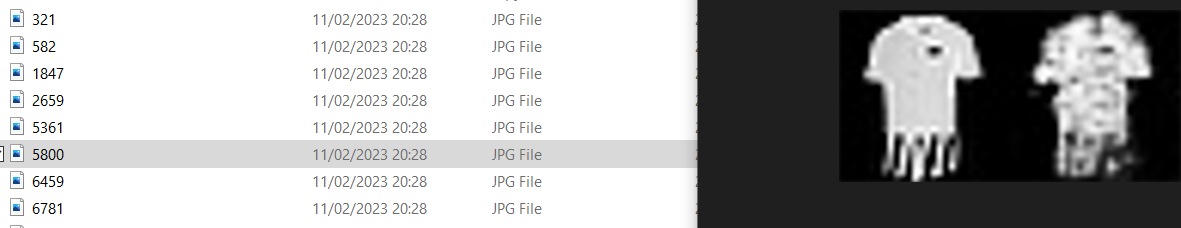

However, for this technique to work, the autoencoder must be great at reconstructing the regular classes (for instance, sandals); otherwise, the false positive rate will be too high. Because of that reason, my model has too high positive.
